# Visual-Area Autolabeler: Training

## About

#### Authors
[Noah C. Benson](mailto:nben@uw.edu)$^{1}$, [Bogeng Song](mailto:bs4283@nyu.edu)$^{2}$, [Shaoling Chen](mailto:sc6995@nyu.edu)$^{3}$, and [Jonathan Winawer](mailto:jonathan.winawer@nyu.edu)$^{2,4}$

$^1$eScience Institute, University of Washington, Seattle, WA 98195  
$^2$Department of Psychology, New York University, New York, NY 10012  
$^3$(Previous Affiliation) Courant Institute for Mathematics, New York University, New York, NY 10012  
$^4$Center for Neural Sciences, New York University, New York, NY 10012  

#### Abstract
This notebook contains code for use with the `visual_autolabel` library, which is packaged with this notebook in its [GitHub repository](https://github.com/noahbenson/visual-autolabel). The library employs the [`neuropythy`](https://github.com/noahbenson/neuropythy) library to enable the training of CNN models using cortical surface data from the Human Connectome Project.

## Configuration

Here we define any configuration item that needs to be set locally for the system running this notebook. Most likely, you will have to edit these in order for the model to work correctly.

In [1]:
# dataset_cache_path
# The directory into which data for the model training should be cached. This
# can be None, but if it is, then the training images will need to be
# regenerated every time the notebook is run.
dataset_cache_path  = '/data/visual-autolabel/datasets'

# analysis_cache_path
# The directory where analysis data (primarily dataframes that compare the
# predictions of various methods) are stored.
analysis_path = '/data/visual-autolabel/analysis'

# model_cache_path
# The directory into which to store models that are generated during training.
# This may be None, but if it is, then the best models will not be saved out to
# disk during rounds of training.
model_cache_path = '/data/visual-autolabel/models'

# dwi_filename_pattern
# Where and how to load diffusion-weighted imaging data files. This may be
# either a string or a tuple of strings; in either case all strings are
# formatted with the target data ('rater' and 'subject') and 'hemisphere' and
# 'tract_name' values then joined using `os.path.join`.
# How this pattern is interpreted can be changed by editing the code for the
# DWIFeature class below.
dwi_filename_pattern = (
    # We load from the directory /data/hcp/tracts/<subject_id>
    '/data', 'hcp', 'tracts', '{subject}',
    # The filename is like lh.VOF_normalized.mgz
    '{hemisphere}.{tract_name}_normalized.mgz')

# hcp_restricted_path
# The path of the CSV file containing the HCP restricted dataset. This file
# must include the genetic data from the HCP young adult dataset. If you
# have configured neuropythy to have access to this file, then you may leave
# it as None. See this website for more information: 
# https://www.humanconnectome.org/study/hcp-young-adult/document/restricted-data-usage
hcp_restricted_path = None

## Initialization

### Dependencies

In [2]:
import os, sys, json

import pimms, torch
import numpy as np
import scipy as sp
import pandas as pd
import neuropythy as ny
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyvolume as ipv

import visual_autolabel as va
import visual_autolabel.benson2024 as proj

proj.config.model_cache_path     = model_cache_path
proj.config.dataset_cache_path   = dataset_cache_path
proj.config.analysis_pat         = analysis_path
proj.config.dwi_filename_pattern = dwi_filename_pattern

In [3]:
%matplotlib inline

In [4]:
# Additional matplotlib preferences; these are just display preferences.
mpl_font_config = {'family':'sans-serif',
                   'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
                   'size': 10,
                   'weight': 'light'}
mpl.rc('font', **mpl_font_config)
mpl.rc('axes', unicode_minus=False)
# We want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*4
mpl.rcParams['savefig.dpi'] = 72*8

## Load Data

In [10]:
# Here we declare the hcp datasets we are using in this notebook.

# Make the HCP partition; if this fails, you probably haven't provided
# the hcp_restricted_path correctly.
(hcp_trn_sids, hcp_val_sids) = proj.hcp.partition(
    hcp_restricted_path=hcp_restricted_path)
# Make the HCP datasets for each input and output type.
hcp_data = proj.hcp.all_datasets()
# From these we can also make subject flatmaps:
hcp_maps = proj.hcp.all_flatmaps(hcp_data)

# Do the same for the NYU datasets.
(nyu_trn_sids, nyu_val_sids) = proj.nyu.partition()
nyu_data = proj.nyu.all_datasets()
nyu_maps = proj.nyu.all_flatmaps(nyu_data)

# We also want to read in the dice dataframes (which contain the dice score
# comparisons of all models/predictors versus all others for all subjects).
dice = proj.all_scores()

# We can add a column that specifies whether the subject is in the validation or
# the training partition; we have to add it here because the twin-status is
# restricted data, and specifying which subjects are trn and which are val
# provides some limited clues about which subjects are twins.
all_val_sids = np.union1d(hcp_val_sids.astype(str), nyu_val_sids)
is_val = np.isin(dice['sid'].astype(str), all_val_sids)
dice.insert(1, 'partition', np.select([is_val, ~is_val], ['val', 'trn']))
# We can separate these out also:
trndice = dice[dice['partition'] == 'trn']
valdice = dice[dice['partition'] == 'val']

### Visualization of Predictions

mean lh ('prior', 'hcp') 0.6760035873128764 ± 0.012005676308085578
mean lh ('inf', 'hcp') 0.7007201490243897 ± 0.012377298179391372
mean lh ('anat', 'hcp') 0.7494454076210015 ± 0.015448872657530588
mean lh ('t1t2', 'hcp') 0.746610692124714 ± 0.014266752928045578
mean lh ('trac', 'hcp') 0.7471161745033578 ± 0.014098823478890576
mean lh ('nofn', 'hcp') 0.7463211940974035 ± 0.013928373012944695
mean lh ('full', 'hcp') 0.8527556544883594 ± 0.013361986452148367
mean lh ('func', 'hcp') 0.8559455426676255 ± 0.013962676842847577
mean lh ('nodw', 'hcp') 0.8543743584458683 ± 0.01313545371085123
mean lh ('not2', 'hcp') 0.851170996305002 ± 0.01355360164707009
mean lh ('rely', 'hcp') 0.8672980691444812 ± 0.010446263043826898
mean lh ('anat', 'nyu') 0.720702996890645 ± 0.02609048897163524
mean lh ('func', 'nyu') 0.38708315855078324 ± 0.052776944529418945
mean lh ('fnyu', 'nyu') 0.8156393313573821 ± 0.05127928040564245
mean rh ('prior', 'hcp') 0.682866123120617 ± 0.016528893645313292
mean rh ('inf', 

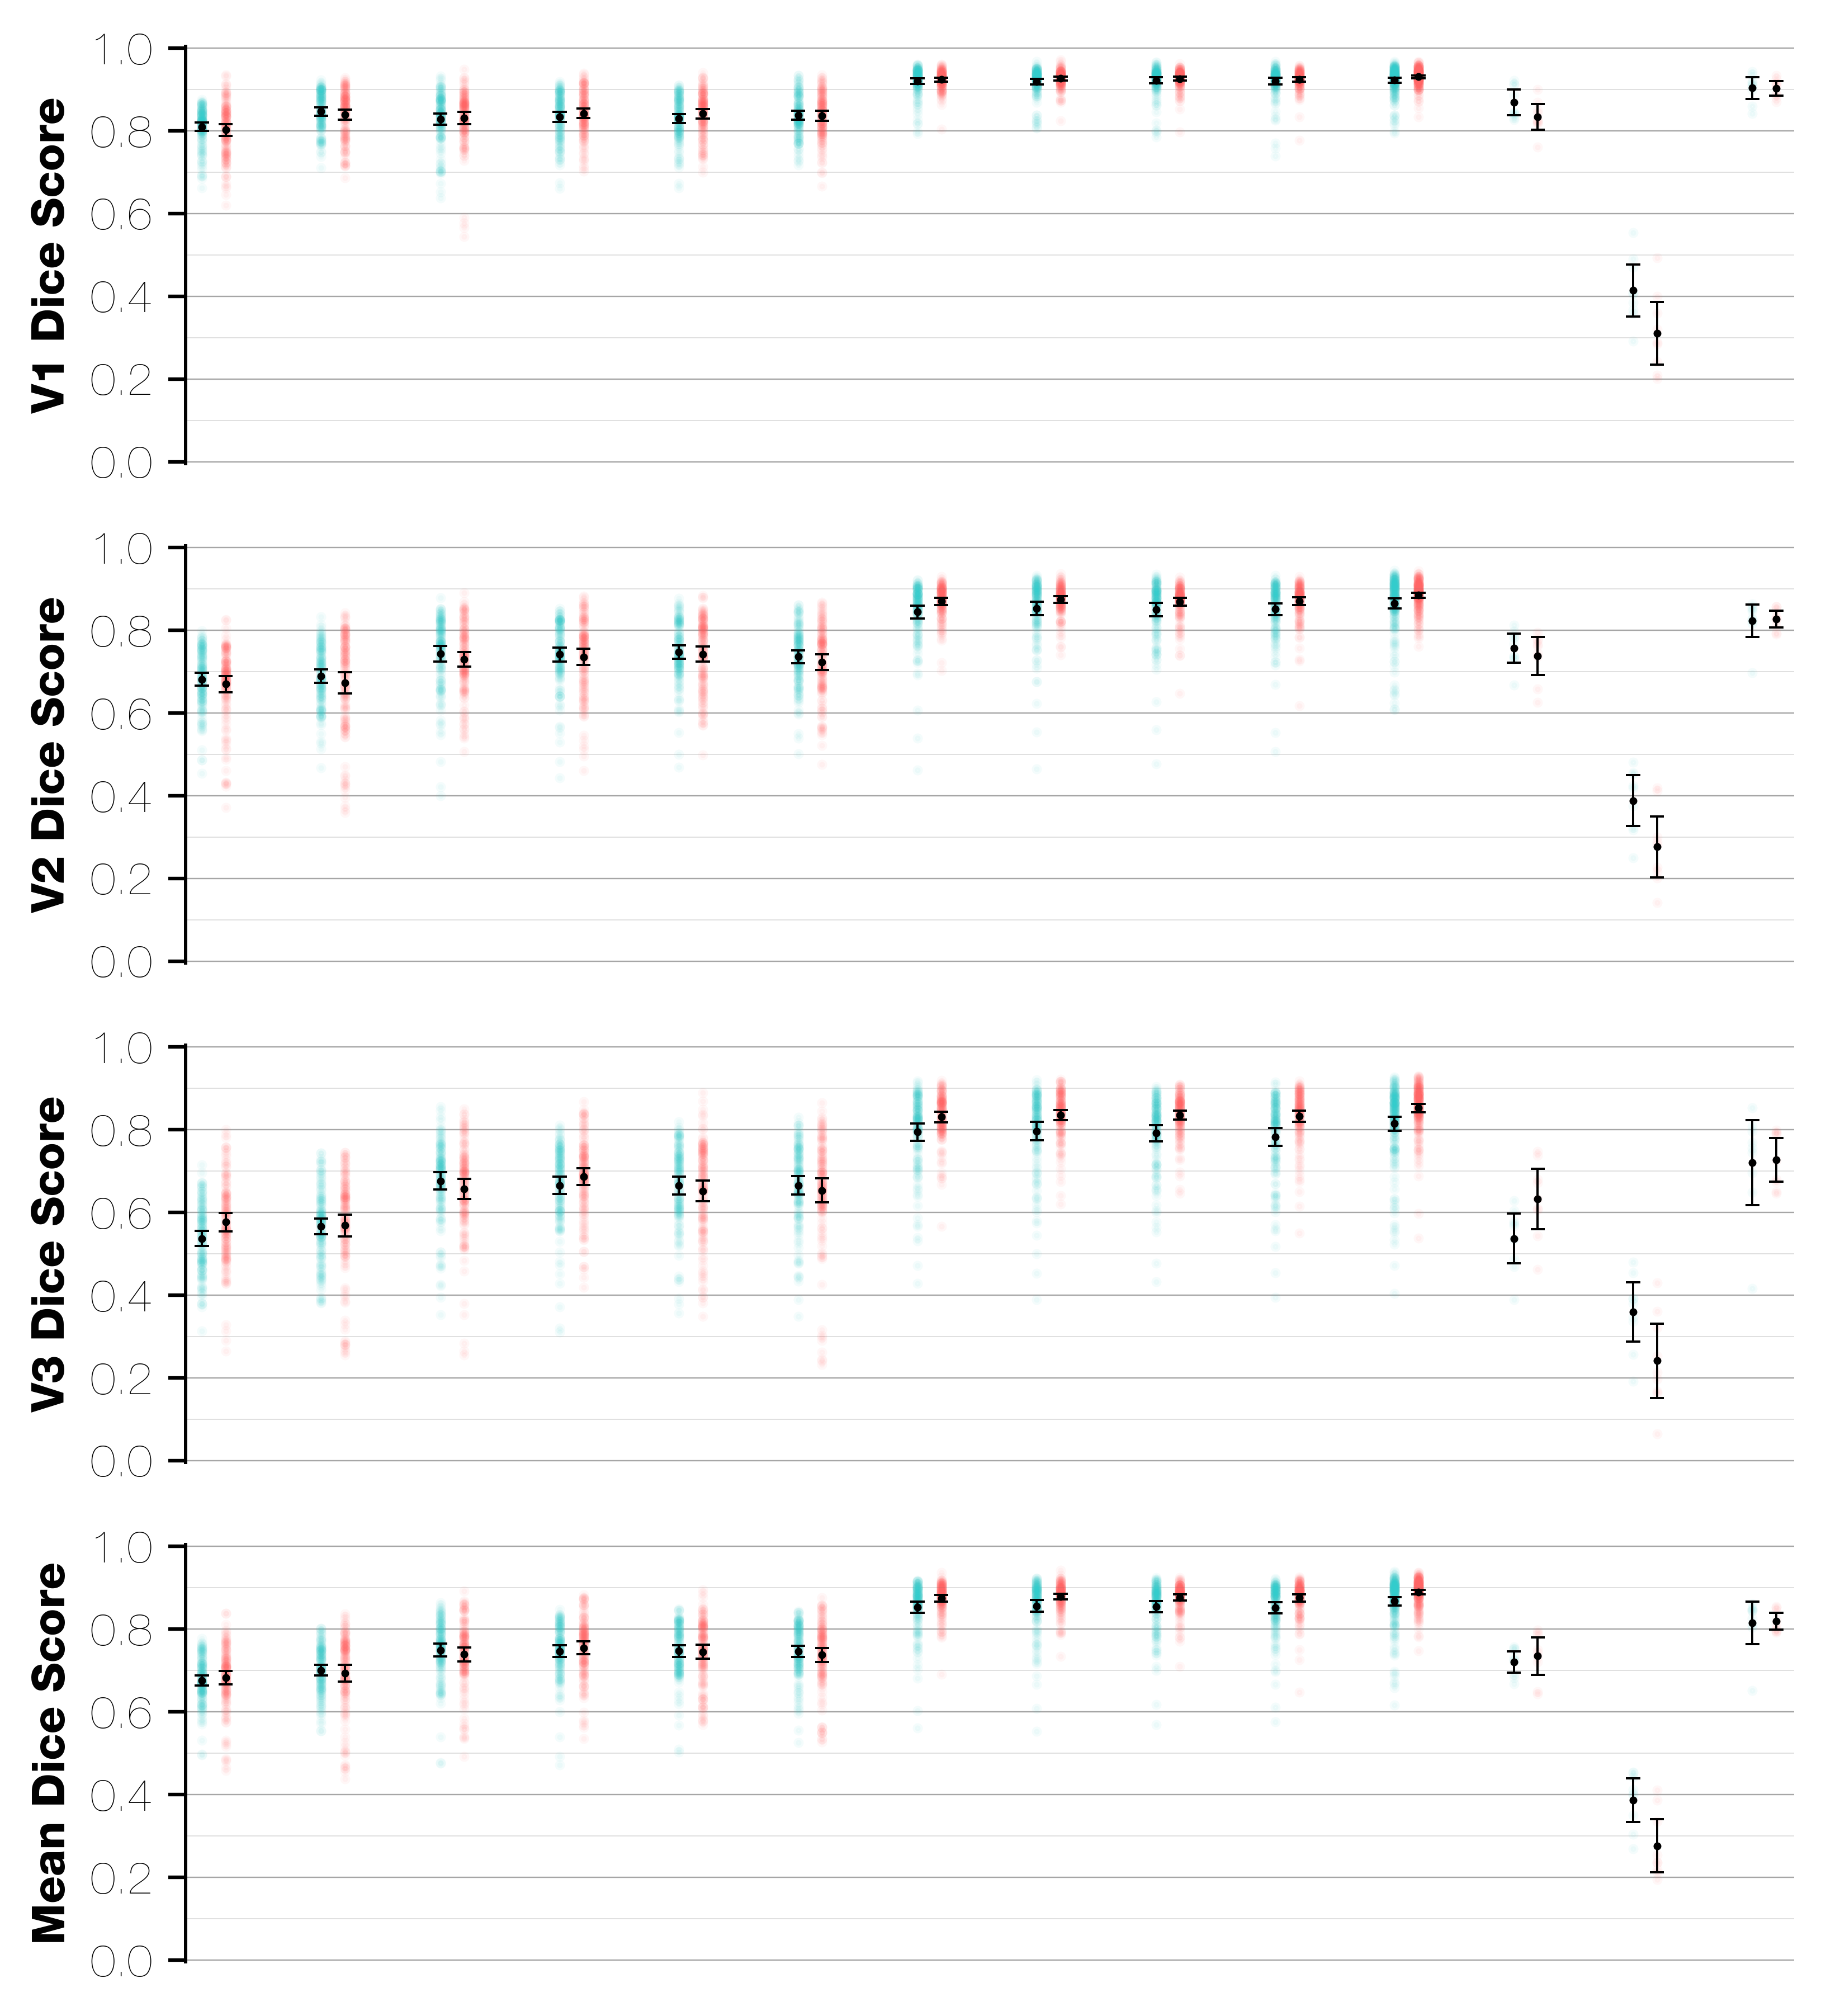

In [65]:
# Options:
parcellation = 'area'
df0 = valdice
colwidth = 1
lrspace = 0.2
ebarlw = 0.5
ebarwidth = 0.15
ebaropts = dict(middle='mean', extent='ste',
                #middle='median', extent='iqr',
                fw=0.05, lw=0.5, ms=1.5)
pointms = 2.5
ebarclr = {'lh':'k', 'rh':'k'}
pointclr = {'lh': (0.2, 0.8, 0.8), 'rh': (1.0, 0.4, 0.4)}

# Option processing & initialization:
yticks = np.linspace(0,1,6)

df0 = df0[df0['parcellation'] == parcellation]
rois = np.unique(df0['label'].values)
nrois = len(rois)
# The models we will be plotting depend on the parcellation type:
mdls = (
    ('prior', 'hcp'), ('inf',   'hcp'),
    ('anat',  'hcp'), ('t1t2',  'hcp'), ('trac',  'hcp'), ('nofn',  'hcp'),
    ('full',  'hcp'), ('func',  'hcp'), ('nodw',  'hcp'), ('not2',  'hcp'),
    ('rely',  'hcp'))
if parcellation == 'area':
    mdls = mdls + (('anat', 'nyu'), ('func', 'nyu'), ('fnyu', 'nyu'))
nmdls = len(mdls)

# We want to perform Bonferroni correction on the confidence intervals we report,
# so we count up the number of confidence intervals we are displaying. This is
# the number of models times the number of hemispheres (2).
bfcount = 2 * nmdls

# Make the figure itself:
(fig,axs) = plt.subplots(nrois, 1, figsize=(5,nrois*1.5), dpi=72*8)
fig.subplots_adjust(0,0,1,1,0.1,0.15)

# Go through each axis/ROI area first:
for (roi,ax) in zip(rois, axs):
    df1 = df0[df0['label'] == roi]
    # We don't use spines.
    for sp in ax.spines.values():
        sp.set_visible(False)
    # We do use ticks.
    ax.set_ylim([-0.025, 1.025])
    ax.set_yticks(yticks)
    # We draw our own y-axis vertical bar.
    ax.set_xlim([-0.25, 0.25 + (nmdls-1)*colwidth])
    ax.plot([-0.25,-0.25], [0,1], 'k-', zorder=-99)
    # Plot some mesh lines.
    for y in yticks:
        ax.plot([-0.25, 0.25 + (nmdls-1)*colwidth], [y, y], '-',
                lw=0.3, c='0.65', zorder=-100)
    for y in np.mean([yticks[:-1], yticks[1:]], 0):
        ax.plot([-0.25, 0.25 + (nmdls-1)*colwidth], [y, y], '-',
                lw=0.2, c='0.85', zorder=-100)
    # Specify the labels and xticks.
    if roi == 'mean':
        ax.set_ylabel("Mean Dice Score")
    elif parcellation == 'area':
        ax.set_ylabel(f'V{roi} Dice Score')
    else:
        ax.set_ylabel(f'E{roi} Dice Score')
    ax.set_xlabel(None)
    ax.set_xticks([])
    # Plot the lh and rh data side-by-side.
    for (h,dx) in zip(['lh','rh'], [-lrspace/2, lrspace/2]):
        df2 = df1[df1['hemisphere'] == h]
        # We want to go through each model in the dataframe.
        for (mdl,x) in zip(mdls, np.arange(nmdls)*colwidth + dx):
            (tag,ds) = mdl
            df3 = df2[(df2['tag'] == tag)]
            df3 = df3[(df3['dataset'] == ds.upper())]
            if len(df3) == 0:
                continue
            ys = df3['score'].values
            if roi == 'mean':
                (mn,mu,mx) = va.plot.summarize_dist(ys, extent='ste', bfcount=bfcount)
                assert np.abs((mx-mu) - (mu-mn)) < 0.00001
                print(roi, h, mdl, mu, '±', (mx-mu))
            va.plot.plot_distbars(x, ys, axes=ax,
                                  lc=ebarclr[h], mc=ebarclr[h], zorder=2,
                                  bfcount=bfcount,
                                  **ebaropts)
            ax.plot([x]*len(ys), ys, '.', ms=pointms, c=pointclr[h],
                    alpha=0.05, zorder=1)
    # If this is the final set of axes, we want to add some labels

plt.savefig(f'/data/visual-autolabel/figures/summary_{parcellation}.pdf',
            bbox_inches='tight',
            transparent=True)

### Plot of Flatmaps with Labels

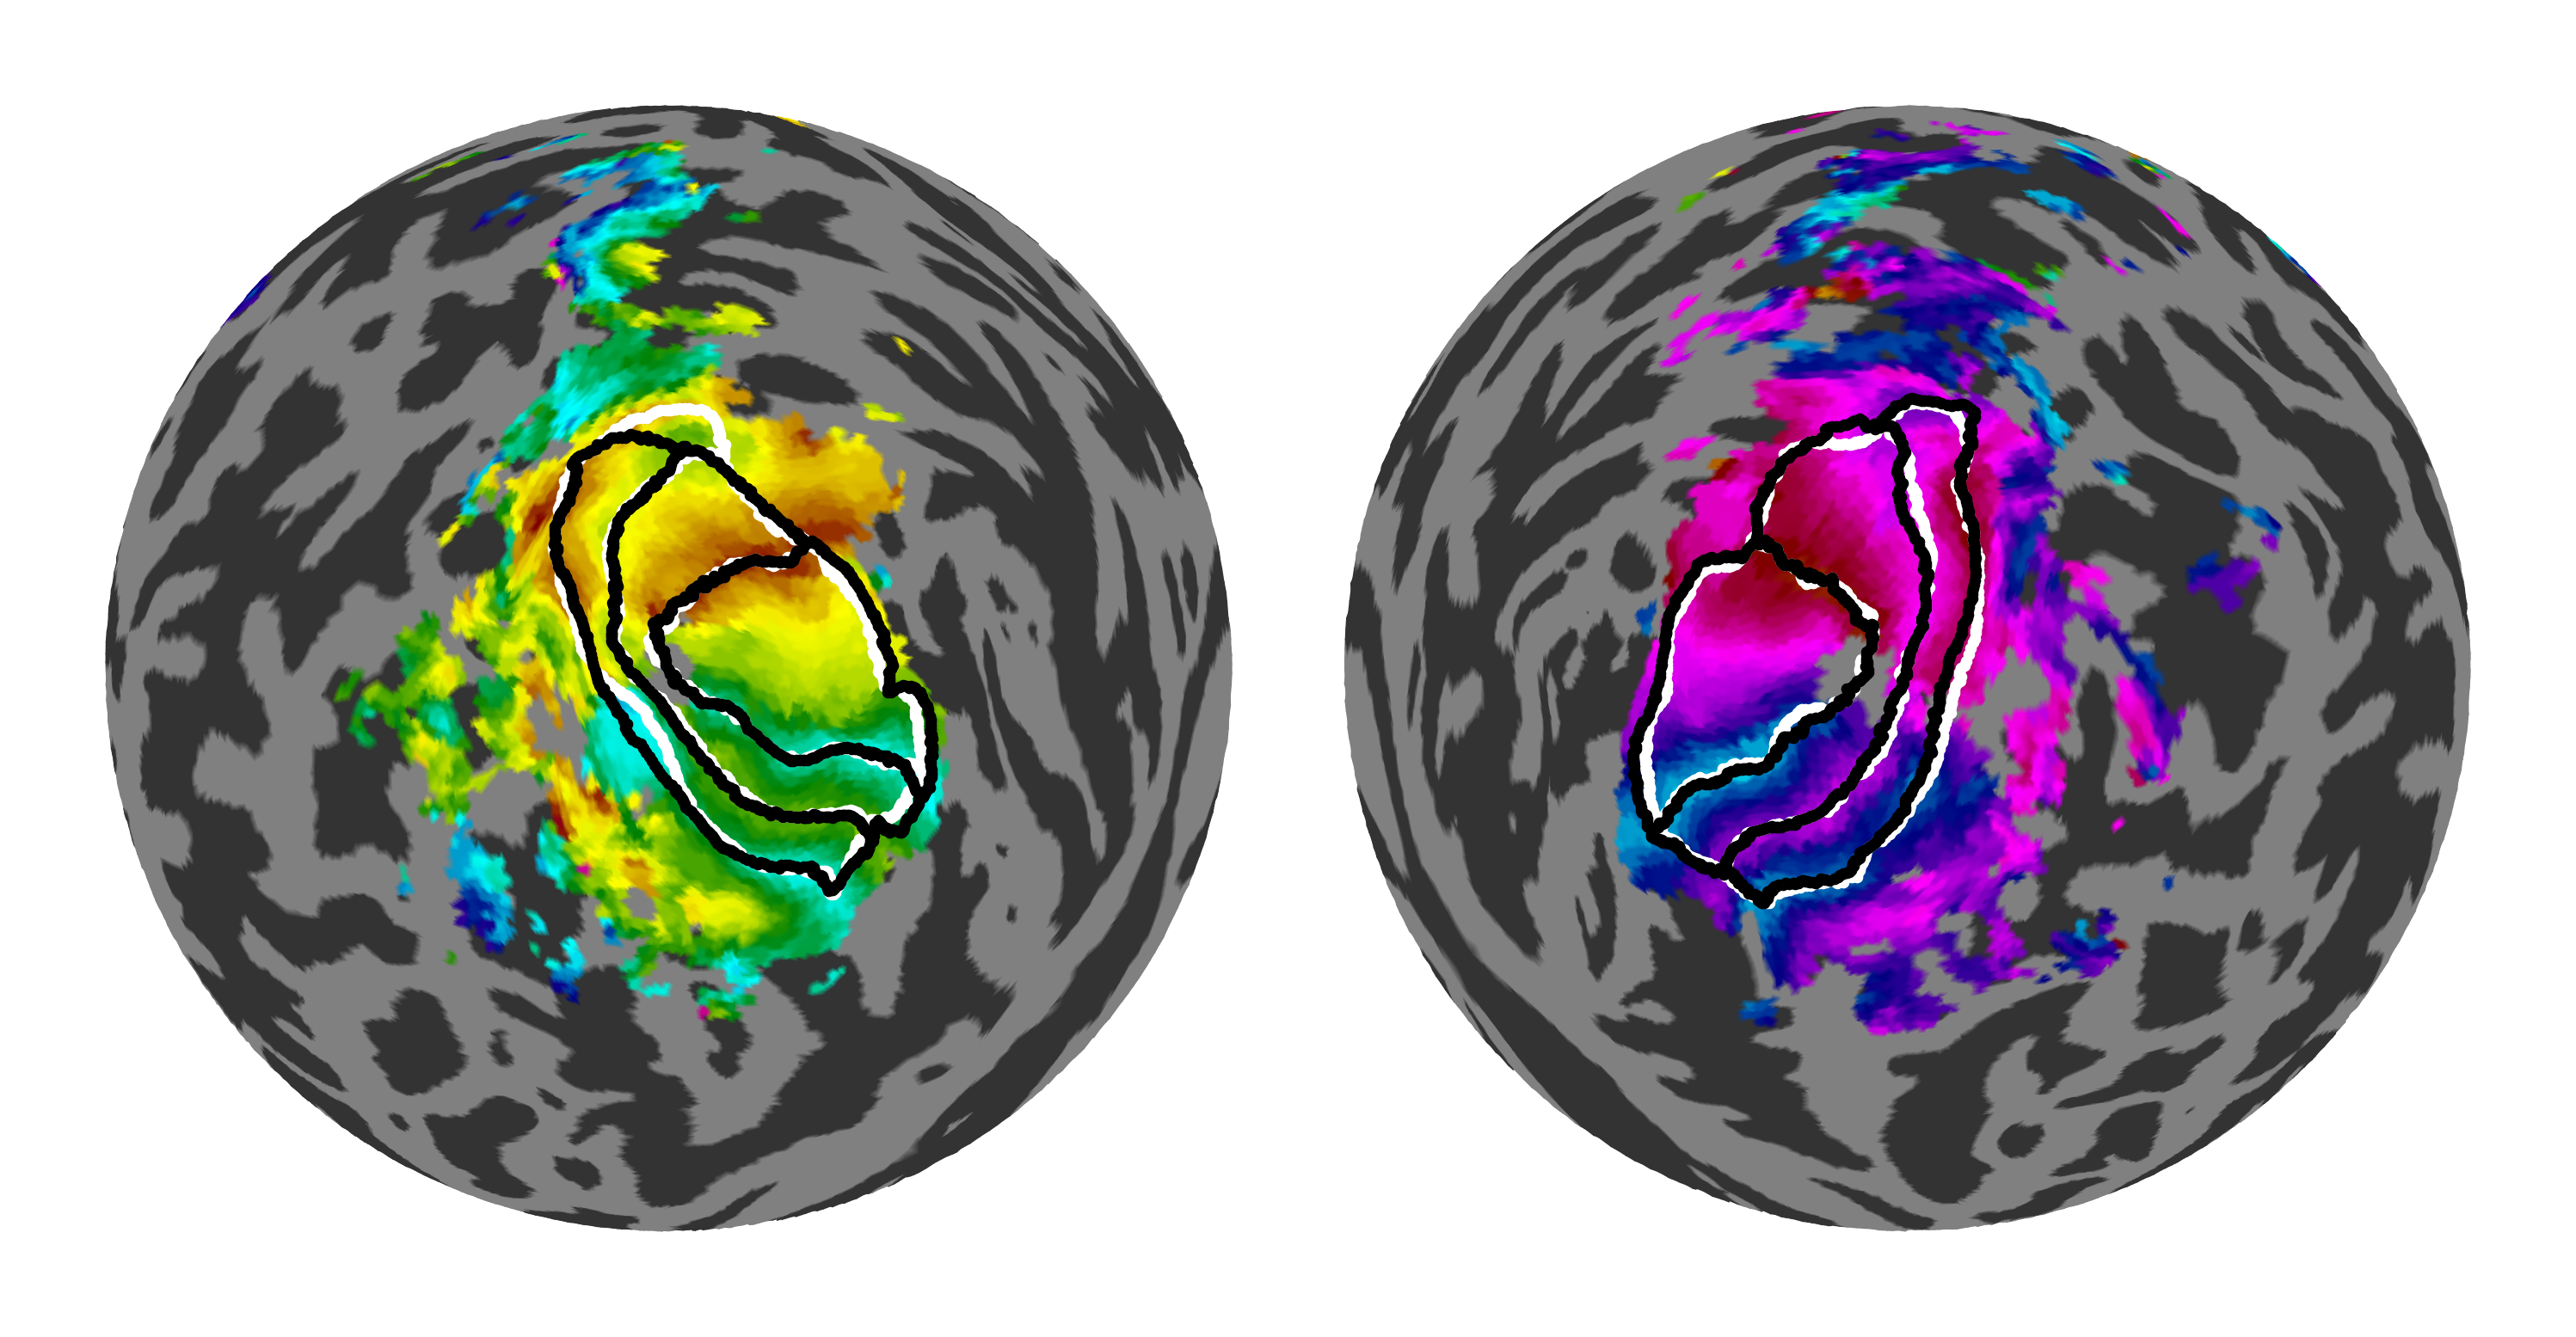

In [37]:
sid = 115017
rater = 'A1'
#prefix = 'func'
#prefix = 'anat'
#prefix = 'tmpl'
prefix = 'A2'

dpi = 72*8
(fig,axs) = plt.subplots(1,2, figsize=(5, 2.5), dpi=dpi)
fig.subplots_adjust(0,0,1,1,0,0)

for (h,hii,ax) in zip(['lh','rh'], [0,1], axs):
    fmap = valmaps[sid][hii]
    if outputs == 'area':
        fmapclr = 'prf_polar_angle'
    else:
        fmapclr = 'prf_eccentricity'
    ny.cortex_plot(fmap, axes=ax, color=fmapclr,
                   mask=('prf_variance_explained', 0.1, 1))
    # Add lines.
    for (pre,clr) in zip([rater, prefix], ['w', 'k']):
        if pre == 'tmpl':
            pre = 'prior'
        elif pre == 'warp':
            pre = 'inf'
        pnm = f'{pre}_visual_{outputs}'
        p = fmap.prop(pnm)
        (u,v) = fmap.tess.indexed_edges
        ii = p[u] != p[v]
        xy = fmap.coordinates
        xy = np.mean([xy[:,u[ii]], xy[:,v[ii]]], axis=0)
        ax.scatter(xy[0],xy[1], c=clr, s=0.5)
    # Turn off axes.
    ax.axis('off')

plt.savefig(f'/data/visual-autolabel/figures/sample-contours_{sid}_{outputs}_{prefix}.png',
            bbox_inches='tight',
            dpi=dpi)

### Hyperparameter Search

In [47]:
def load_cell(cell_path):
    """Loads the meta-data for one cell of the grid.
    
    `load_cell(path)` loads the cell at the given `path`, which should be a
    directory containing the `opts.json`, `plan.json`, and `run.log` files.
    """
    from pathlib import Path
    cell_path = Path(cell_path)
    with (cell_path / 'opts.json').open('rt') as fl:
        opts = json.load(fl)
    opts = dict({'cell_id': int(opts['model_key'][4:])}, **opts)
    with (cell_path / 'plan.json').open('rt') as fl:
        plan = json.load(fl)
    for (ii,p) in enumerate(plan):
        for (k,v) in p.items():
            opts[f'{k}_{ii}'] = v
    with (cell_path / 'run.log').open('rt') as fl:
        log = fl.readlines()
    return log

In [61]:
from pathlib import Path
grid_path = Path('/data/visual-autolabel/grid/cells')
log = load_cell(grid_path / 'grid00111')
#min([float(ln.split()[9]) for ln in log if ln.endswith('*\n')])
it0s = [ii for (ii,ln) in enumerate(log) if ln.startswith('Iteration')]
it0s.append(-1)
bests = [
    min([float(ln.split()[9]) for ln in log[ii0:ii1] if ln.endswith('*\n')])
    for (ii0,ii1) in zip(it0s[:-1], it0s[1:])]
bests

[0.084, 0.09]

In [18]:
from pathlib import Path
grid_path = Path('/data/visual-autolabel/grid/cells')

def load_cell(cell_path): 
    """Loads the meta-data for one cell of the grid.
    
    `load_cell(path)` loads the cell at the given `path`, which should be a
    directory containing the `opts.json`, `plan.json`, and `run.log` files.
    """
    from pathlib import Path
    cell_path = Path(cell_path)
    with (cell_path / 'opts.json').open('rt') as fl:
        opts = json.load(fl)
    opts = dict({'cell_id': int(opts['model_key'][4:])}, **opts)
    with (cell_path / 'plan.json').open('rt') as fl:
        plan = json.load(fl)
    for (ii,p) in enumerate(plan):
        for (k,v) in p.items():
            opts[f'{k}_{ii}'] = v
    with (cell_path / 'run.log').open('rt') as fl:
        log = fl.readlines()
    it0s = [ii for (ii,ln) in enumerate(log) if ln.startswith('Iteration')]
    it0s.append(-1)
    losses = np.array(
        [min([float(ln.split()[9])
              for ln in log[ii0:ii1]
              if ln.endswith('*\n')])
         for (ii0,ii1) in zip(it0s[:-1], it0s[1:])])
    if len(losses) > 0:
        opts['loss_mean'] = np.mean(losses)
        opts['loss_median'] = np.median(losses)
        opts['loss_std'] = np.std(losses)
        opts['loss_max'] = np.max(losses)
        opts['loss_min'] = np.min(losses)
    else:
        opts['loss_mean'] = np.nan
        opts['loss_median'] = np.nan
        opts['loss_std'] = np.nan
        opts['loss_max'] = np.nan
        opts['loss_min'] = np.nan
    opts['partition'] = va.partition_id(opts['partition'])
    return opts

cells = []
for k in range(1800):
    try:
        cell = load_cell(grid_path / f'grid{k:05d}')
    except Exception as err:
        print(f"ERROR {k}: {err}")
        continue
    cells.append(cell)
cells_full = pd.DataFrame(cells)
cells = cells_full.drop(
    columns=[
        'pretrained', 'multiproc', 
        'model_cache_path', 'data_cache_path',
        'model_key', 'partition',
        'lr_1', 'lr_2', 'bce_weight_1', 'bce_weight_2'])
cells = cells.rename(columns=dict(lr_0='lr', bce_weight_0='bce_weight'))
################################################################################

In [19]:
variates = []
for c in cells.columns:
    if 'loss' in c:
        continue
    if c.endswith('_1') or c.endswith('_2'):
        continue
    if c in ('until', 'model_key', 'cell_id'):
        continue
    if len(np.unique(cells[c].values)) > 1:
        variates.append(c)
variates = {k: np.unique(cells[k]) for k in variates}

def cellselect(cells, col='loss_min', variates=variates, **kw):
    df = cells
    srt = []
    for (k,v) in kw.items():
        if v is None:
            srt.append(k)
        else:
            df = df[df[k] == v]
    df = df.sort_values(srt)
    for k in srt:
        vs = variates[k]
        
    shape = [len(np.unique(df[k].values)) for k in srt]
    return np.reshape(df[col].values, shape)

variates

{'base_model': array(['resnet18', 'resnet34'], dtype=object),
 'gamma': array([0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 'batch_size': array([2, 4, 6]),
 'inputs': array(['anat', 'full'], dtype=object),
 'prediction': array(['area', 'ring'], dtype=object),
 'lr': array([0.00167, 0.0025 , 0.00375, 0.00562, 0.00844]),
 'bce_weight': array([0.5 , 0.67, 0.75])}

In [20]:
def plotgrid(cells, inputs, outputs, base_model, col='loss_min',
             vmin=0, vmax=0.2, cmap='cividis',
             figsize=(7,7), dpi=512,
             gammas=(0.8, 0.85, 0.9, 0.95, 1),
             lrs=(0.00167, 0.0025 , 0.00375, 0.00562, 0.00844),
             axes=None,
             star=True):
    from warnings import warn
    # First get the set of cells we are planning to use:
    cells = cells[(cells['inputs'] == inputs) & (cells['prediction'] == outputs)]
    cells = cells[cells['base_model'] == base_model]
    # We now need a grid of 3 x 3 matrices, each of which will be 5x5:
    if axes is None:
        (fig,axs) = plt.subplots(3, 3, dpi=dpi, figsize=figsize, sharex=True, sharey=True)
    else:
        axs = axes
        fig = None
    posmin = None
    totmin = np.inf
    mtcs = []
    for (axrow,batch_size) in zip(axs, [2,4,6]):
        subcells0 = cells[cells['batch_size'] == batch_size]
        mtxrow = []
        for (ax, bcew0) in zip(axrow, [0.5, 0.67, 0.75]):
            # Get the subset of cells that match:
            subcells = subcells0[subcells0['bce_weight'] == bcew0]
            # Now go through and make the matrix (there may be values missing, so we
            # build this up iteratively).
            mtx = []
            g = []
            l = []
            for gamma in gammas:
                row = []
                for lr in lrs:
                    g.append(gamma)
                    l.append(lr)
                    cell = subcells[(subcells['gamma'] == gamma) & (subcells['lr'] == lr)]
                    if len(cell) == 0:
                        warn(f"missing cell: {inputs}/{outputs}/"
                             f"{base_model}/{batch_size}/{bcew0}/{gamma}/{lr}")
                        row.append(np.nan)
                    elif len(cell) > 1:
                        warn(f"identical cells: {[r['cell_id'] for (ii,r) in cell.iterrows()]}")
                        row.append(np.nan)
                    else:
                        row.append(cell[col].values[0])
                mtx.append(row)
            mtx = np.round(np.array(mtx), 3)
            mtcs.append(mtx)
            ax.imshow(mtx, vmin=vmin, vmax=vmax, cmap=cmap)
            ax.invert_yaxis()
            ax.set_title(f'batch={batch_size}, BCE$_0$={bcew0}')
            # We want to track the smallest value
            mtxmin_ii = np.nanargmin(mtx)
            mtxmin = mtx.flat[mtxmin_ii]
            if mtxmin < totmin:
                totmin = mtxmin
                posmin = {
                    'batch_size': batch_size, 'bce_weight': bcew0,
                    'gamma': g[mtxmin_ii], 'lr': l[mtxmin_ii],
                    'value': totmin}
    for ax in axs[:,0]:
        ax.set_ylabel('$\gamma$')
        ax.set_yticks(range(len(gammas)))
        ax.set_yticklabels(gammas)
    for ax in axs[-1,:]:
        ax.set_xlabel('Learning Rate [$10^{-3}$]')
        ax.set_xticks(range(len(lrs)))
        ax.set_xticklabels([f'{lr*1000:3.2f}' for lr in lrs])
    if star and np.isfinite(totmin):
        for (ax,mtx) in zip(axs.flat, mtcs):
            for (ri,row) in enumerate(mtx):
                for (ci,val) in enumerate(row):
                    if np.round(val, 3) <= totmin:
                        ax.plot(ci, ri, 'w*', zorder=10)
                        print(ci, ri, np.round(val, 3))
    if fig is not None:
        fig.subplots_adjust(0,0,1,1,0.2,0.2)
    return posmin

2 2 0.159
3 1 0.16
[anat:area]  ResNet18: 0.16;  ResNet34: 0.16


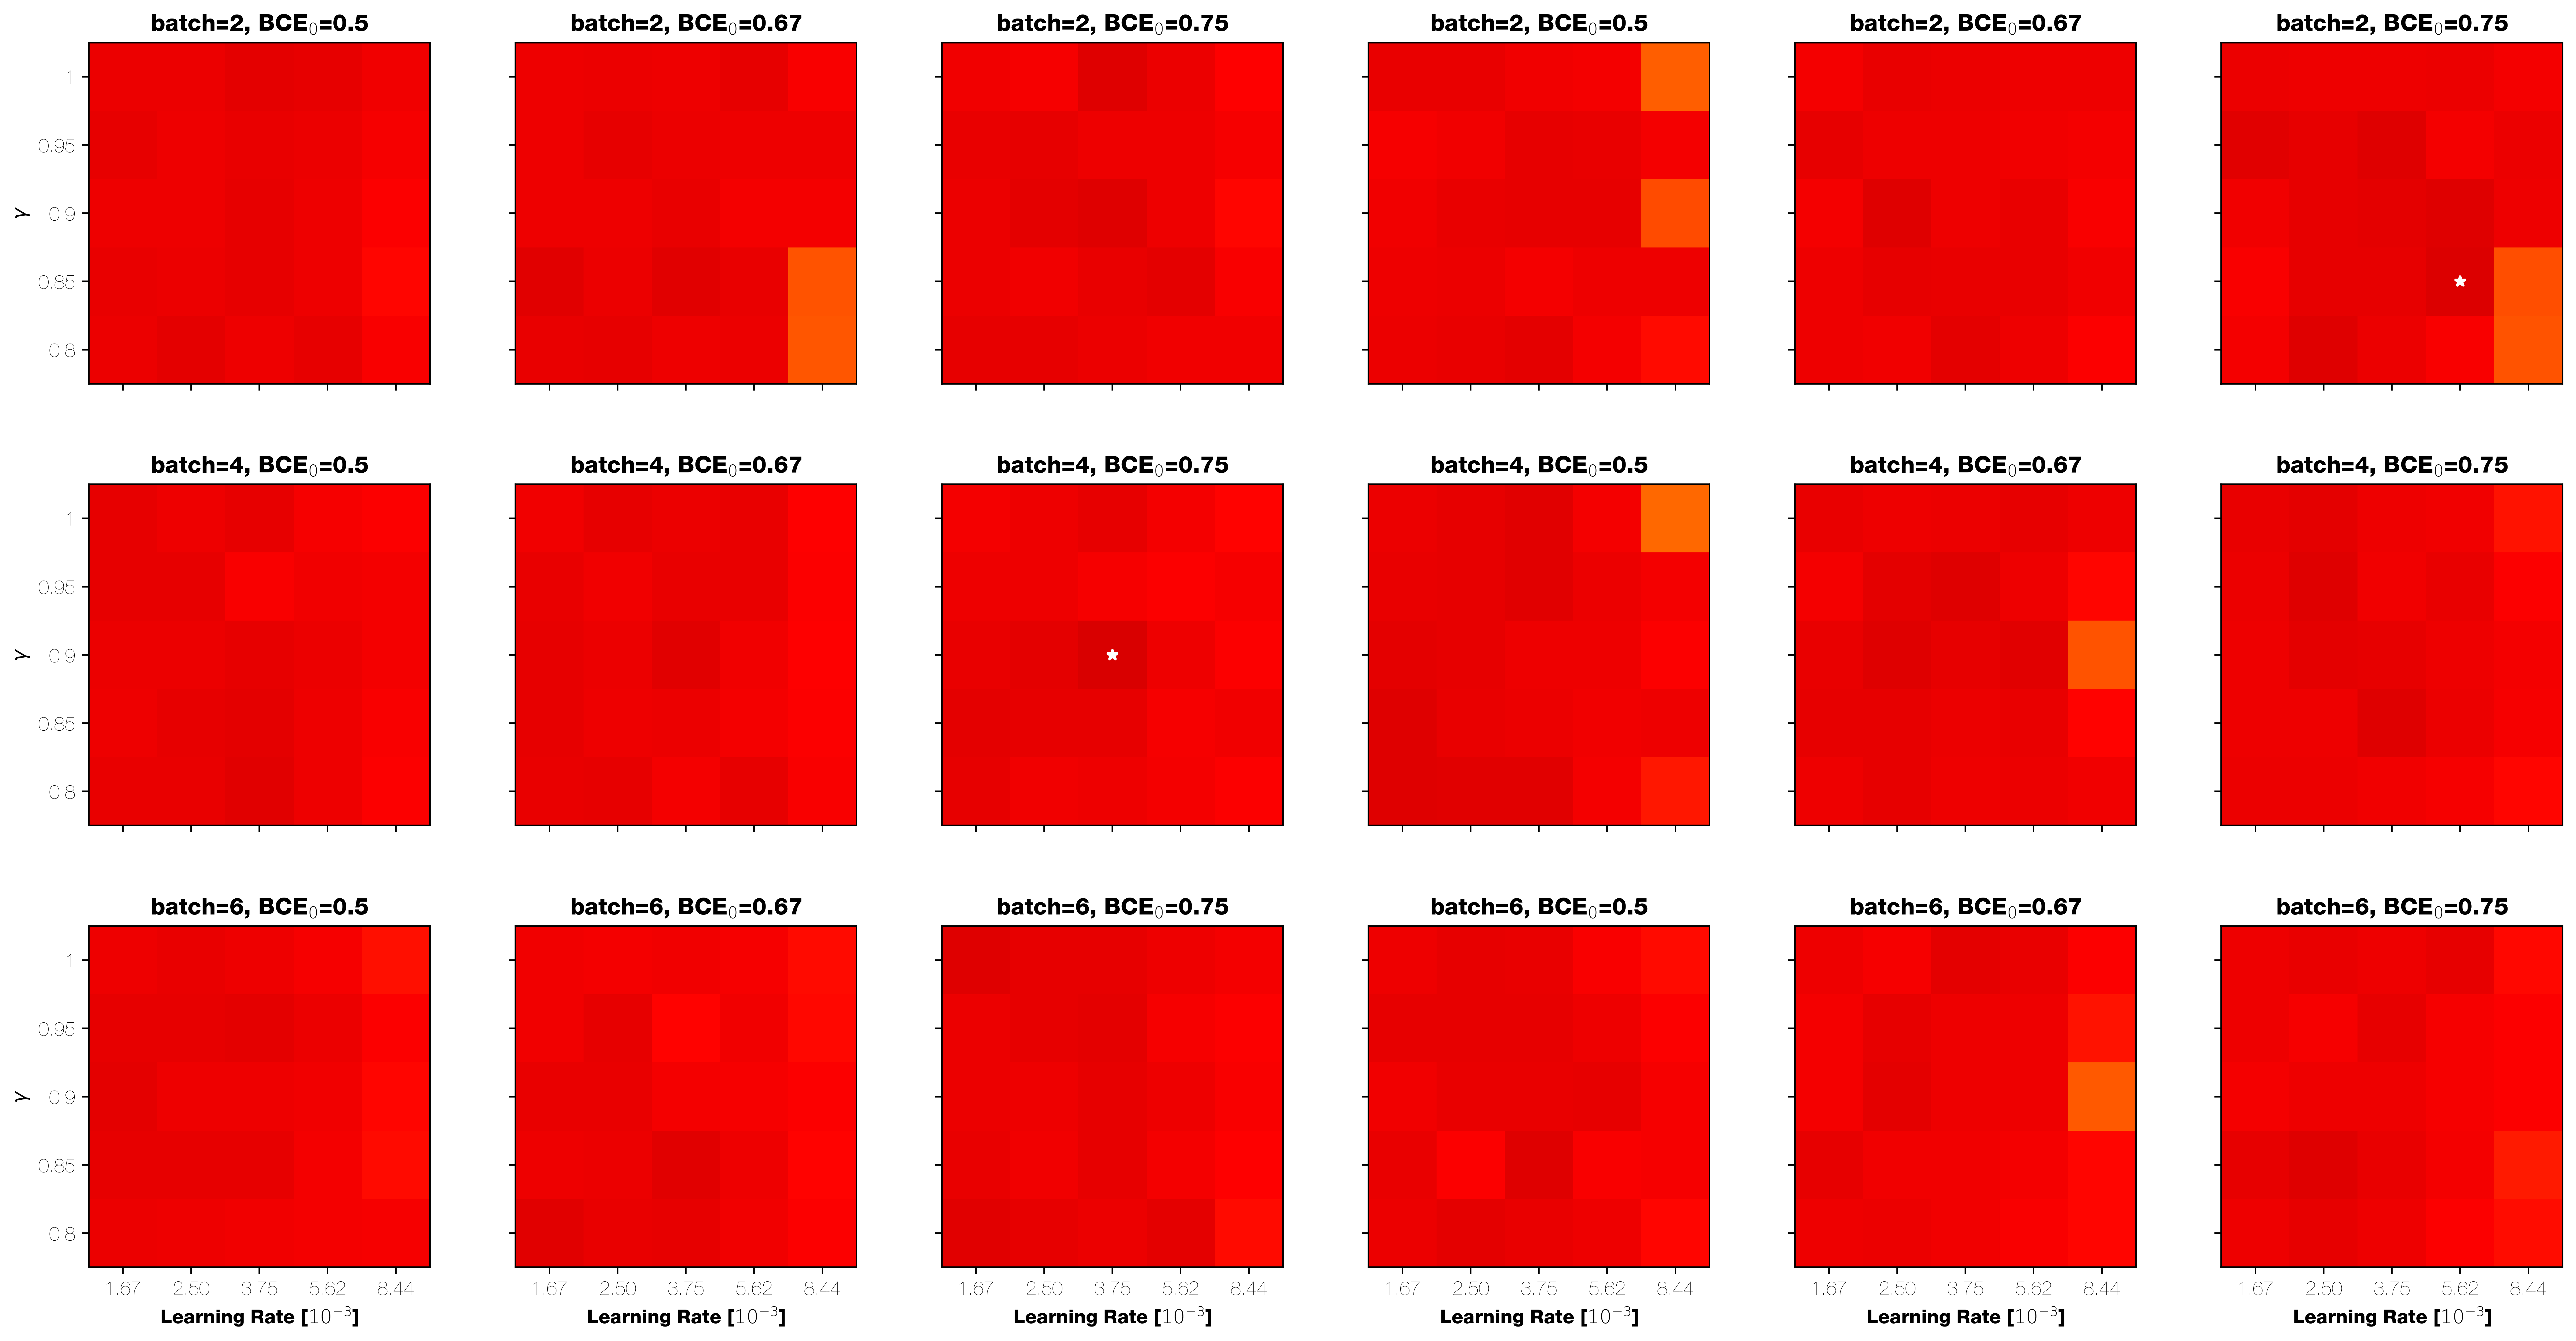

1 4 0.067
2 3 0.067
0 4 0.067
2 2 0.067
0 4 0.067
1 3 0.067
[full:area]  ResNet18: 0.07;  ResNet34: 0.07


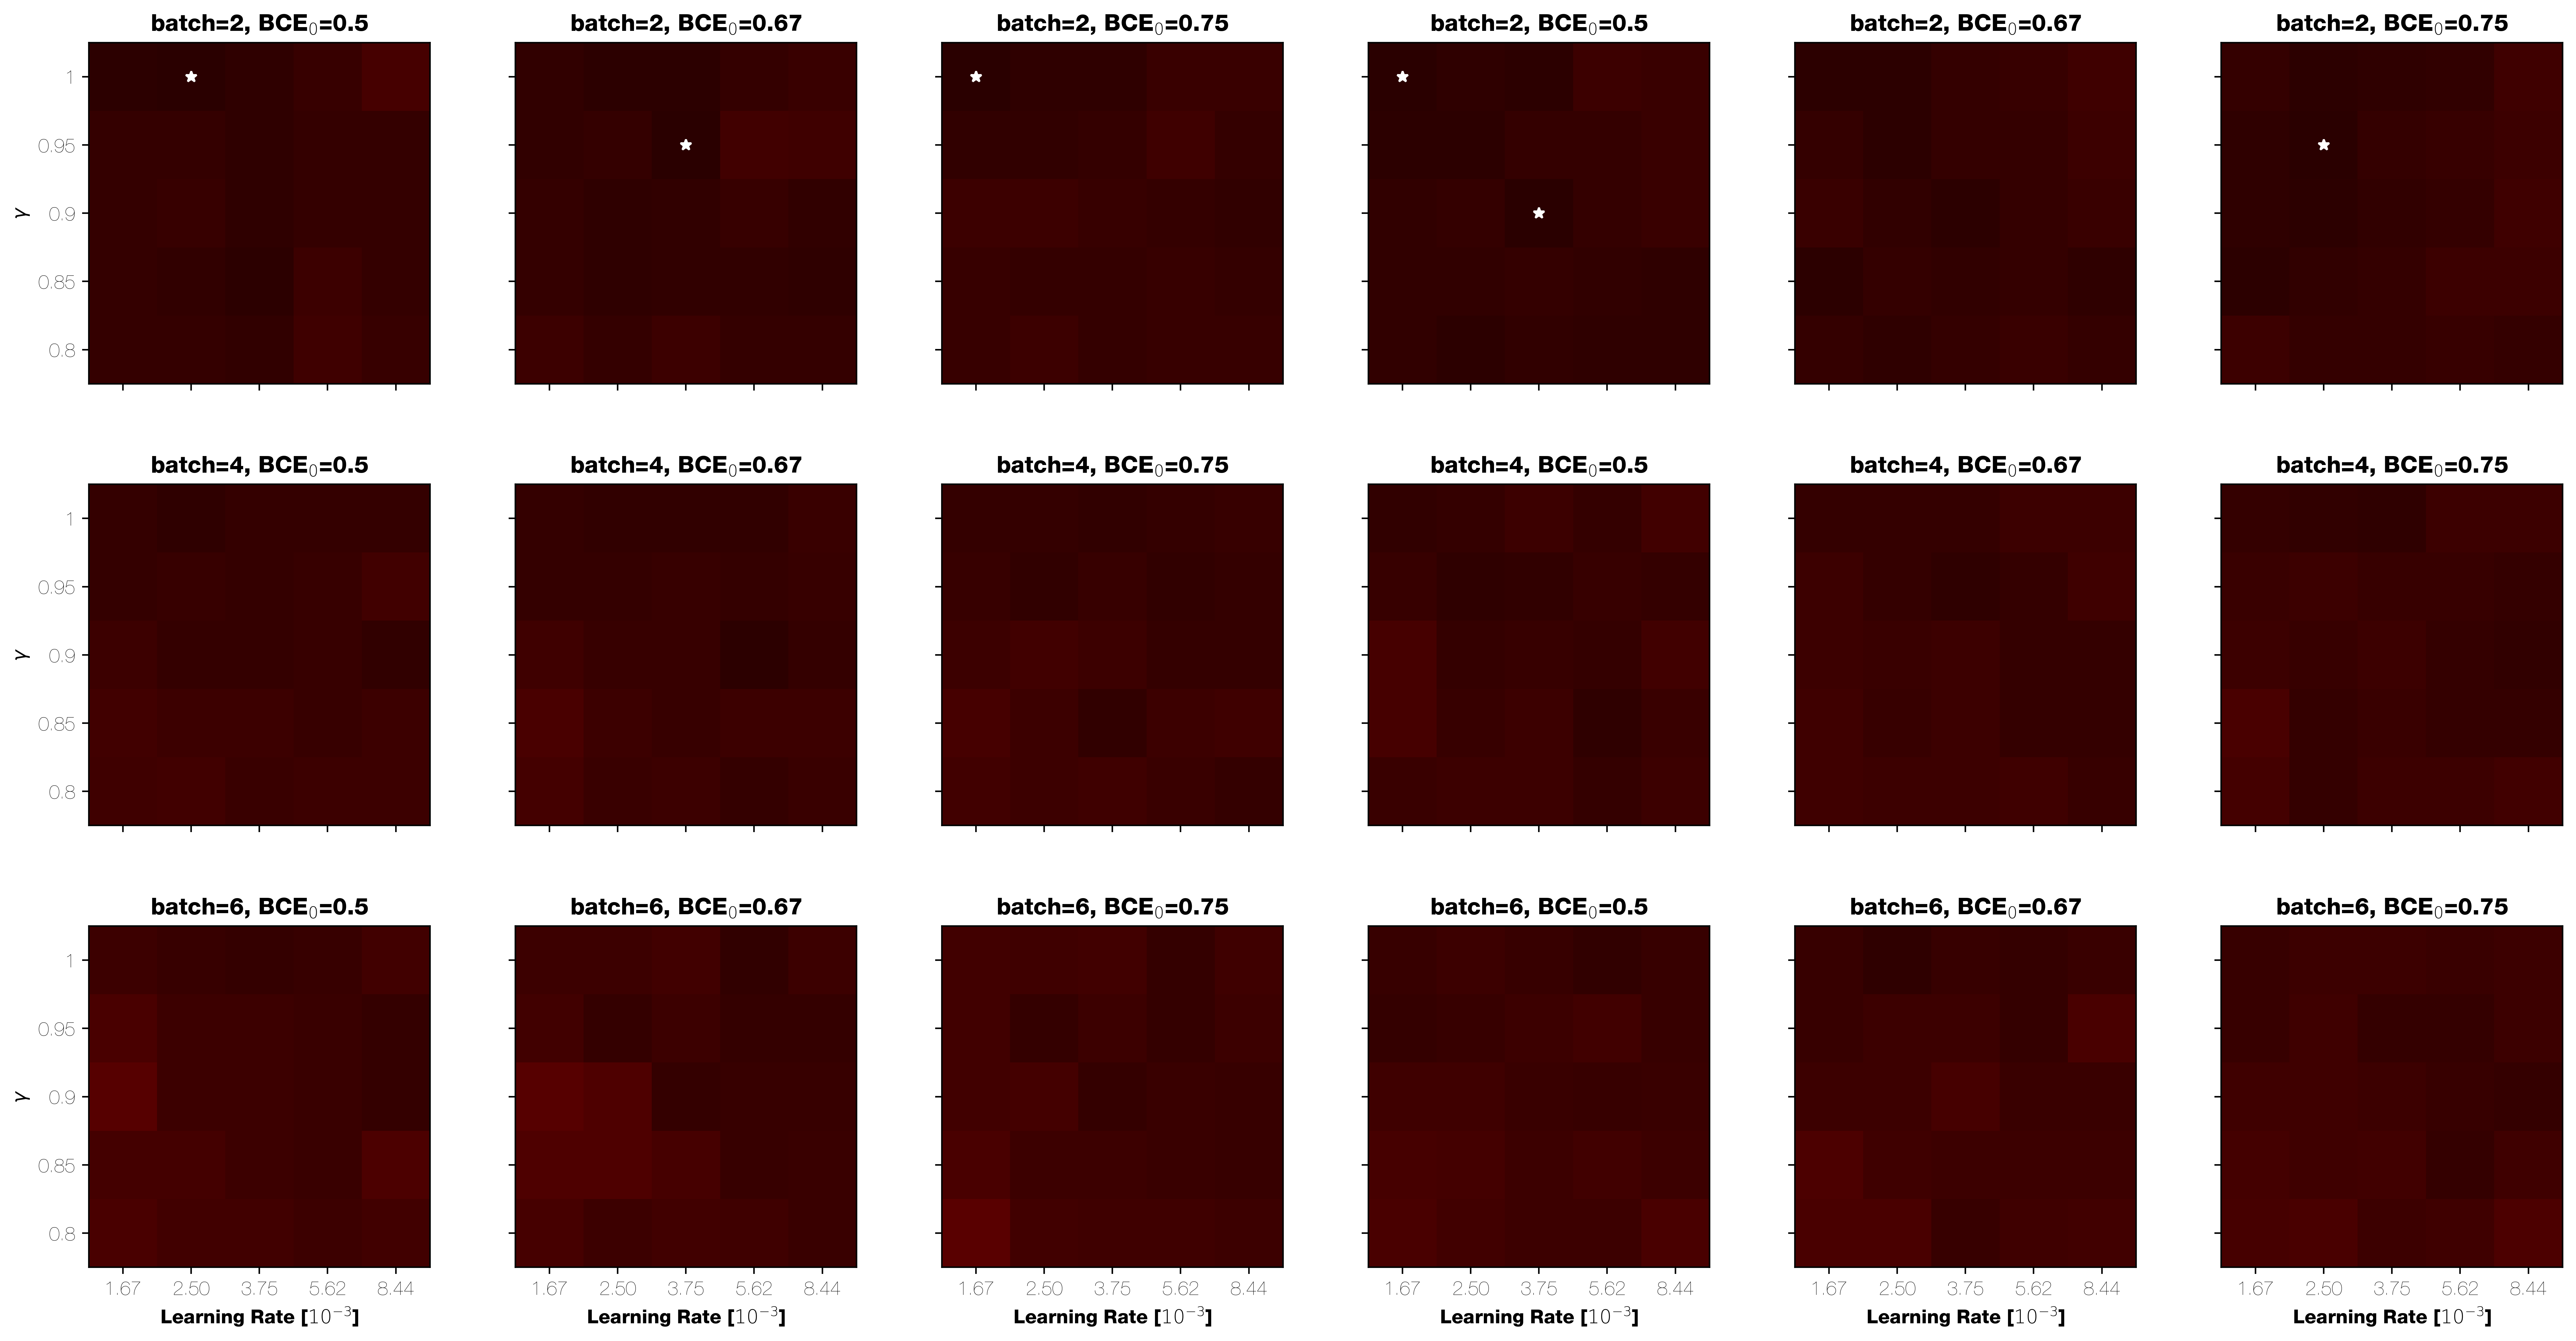

3 2 0.287
1 2 0.288
[anat:ring]  ResNet18: 0.29;  ResNet34: 0.29


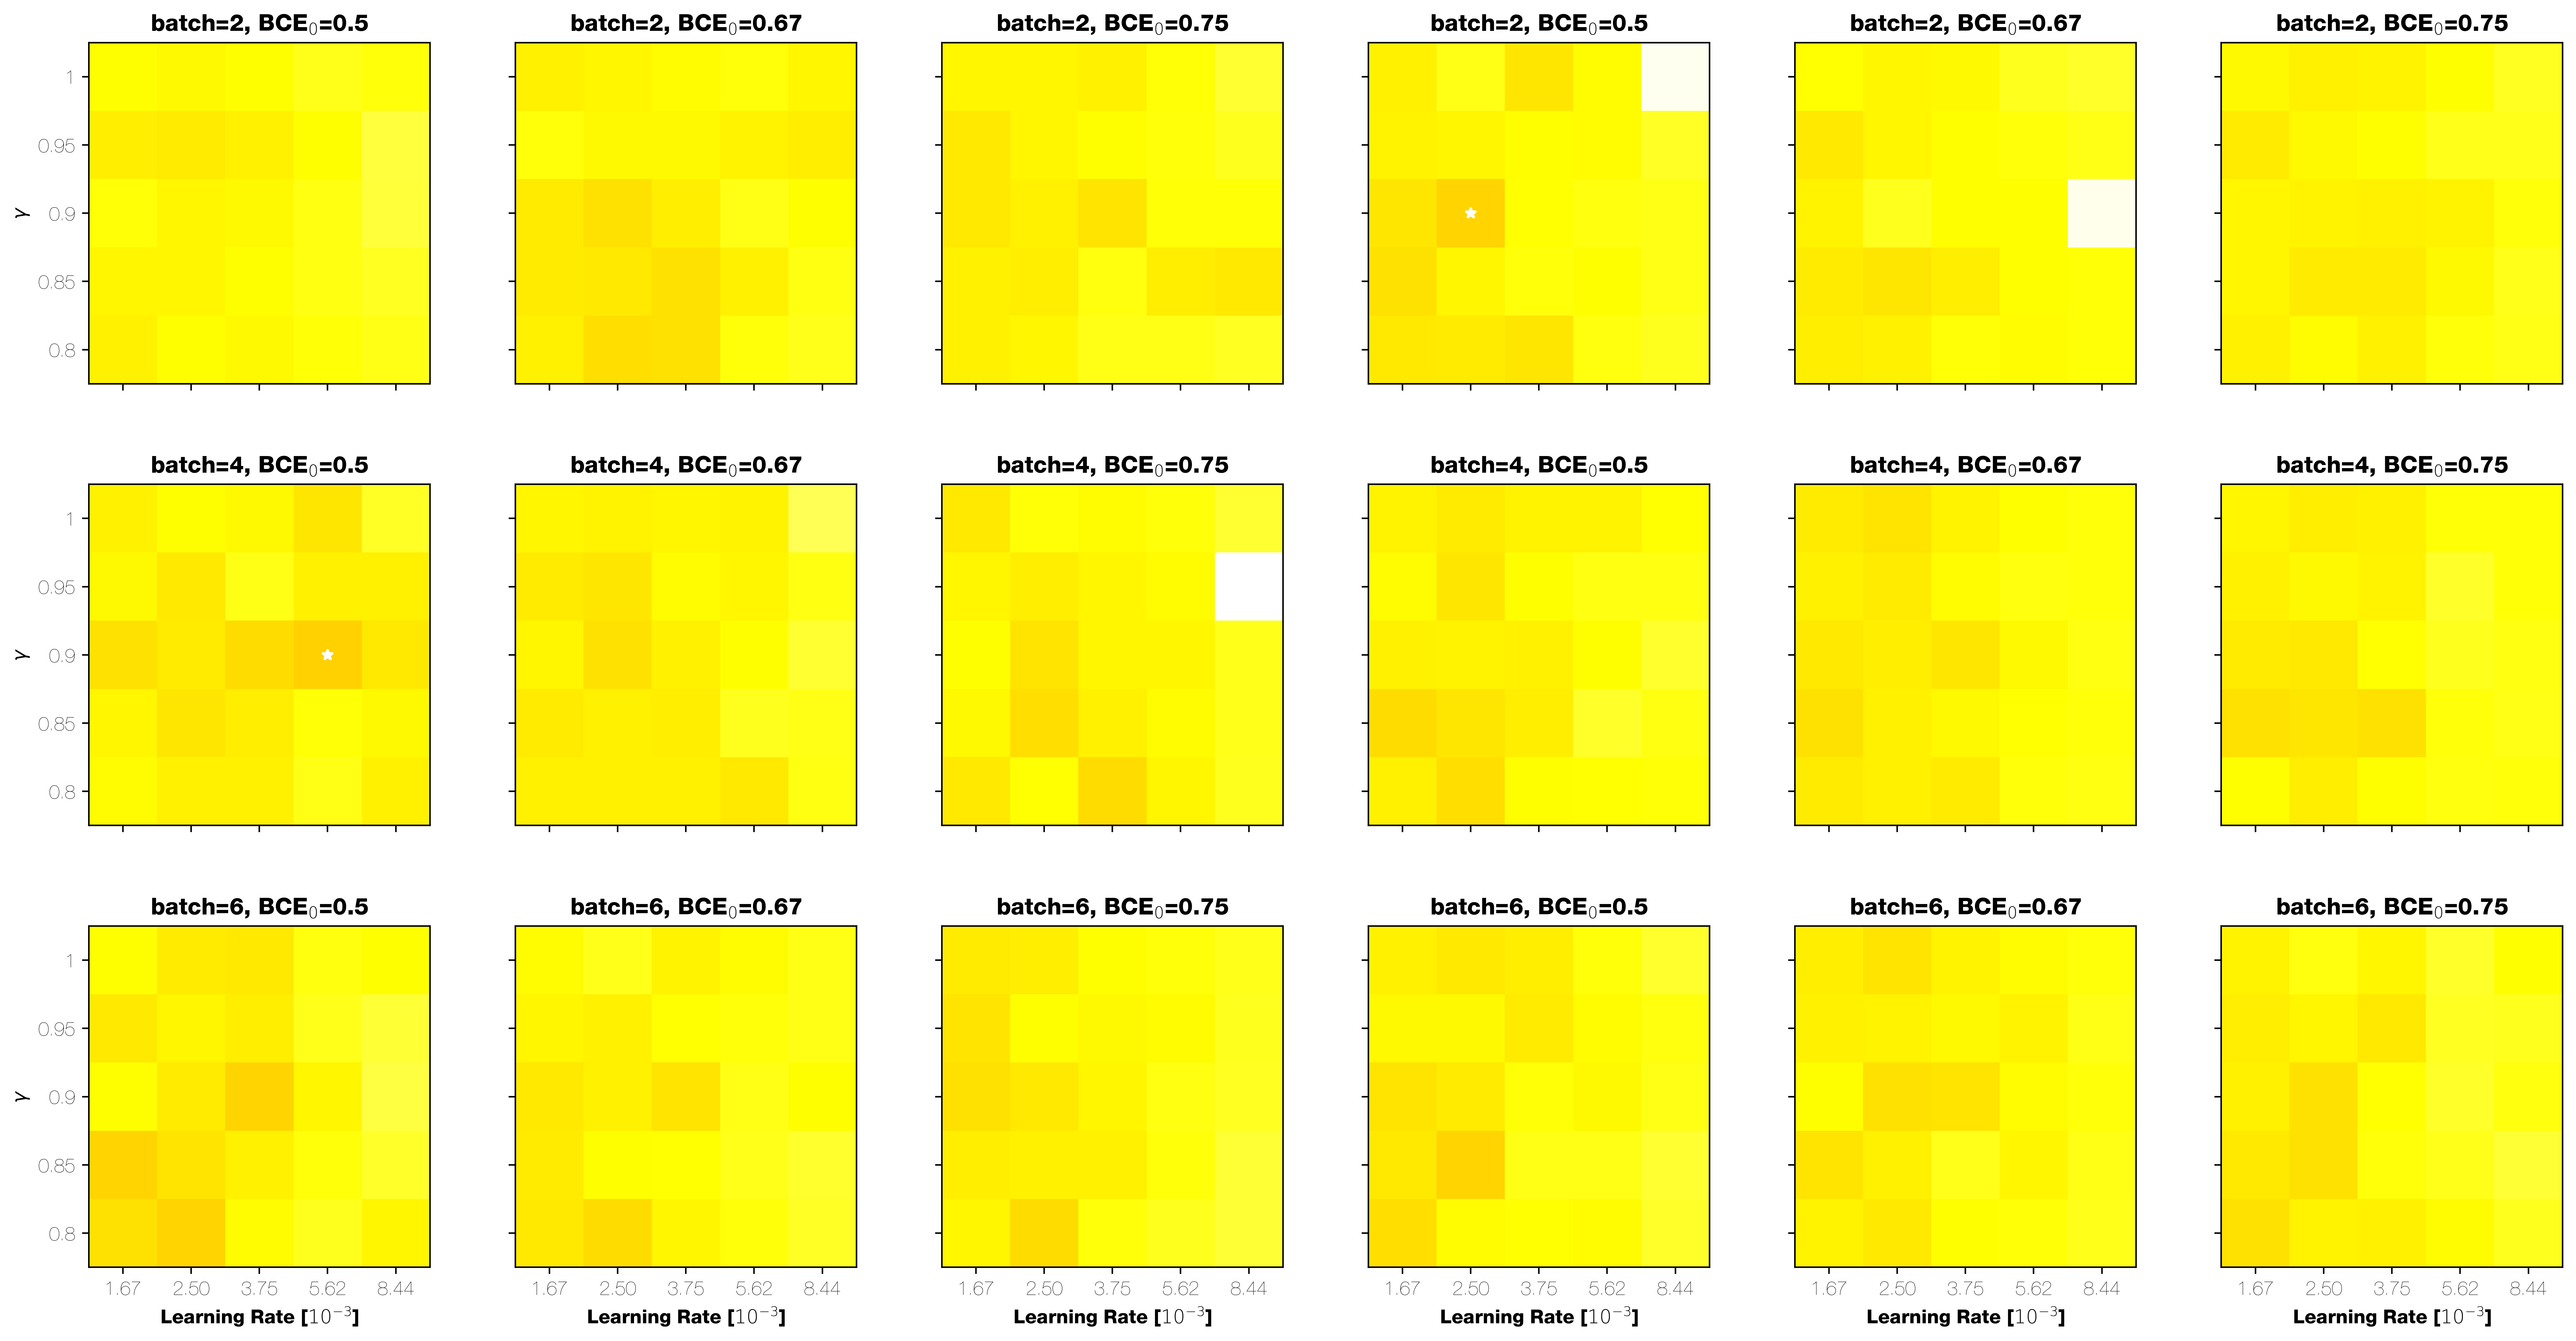

0 3 0.093
2 0 0.095
1 1 0.095
[full:ring]  ResNet18: 0.09;  ResNet34: 0.10


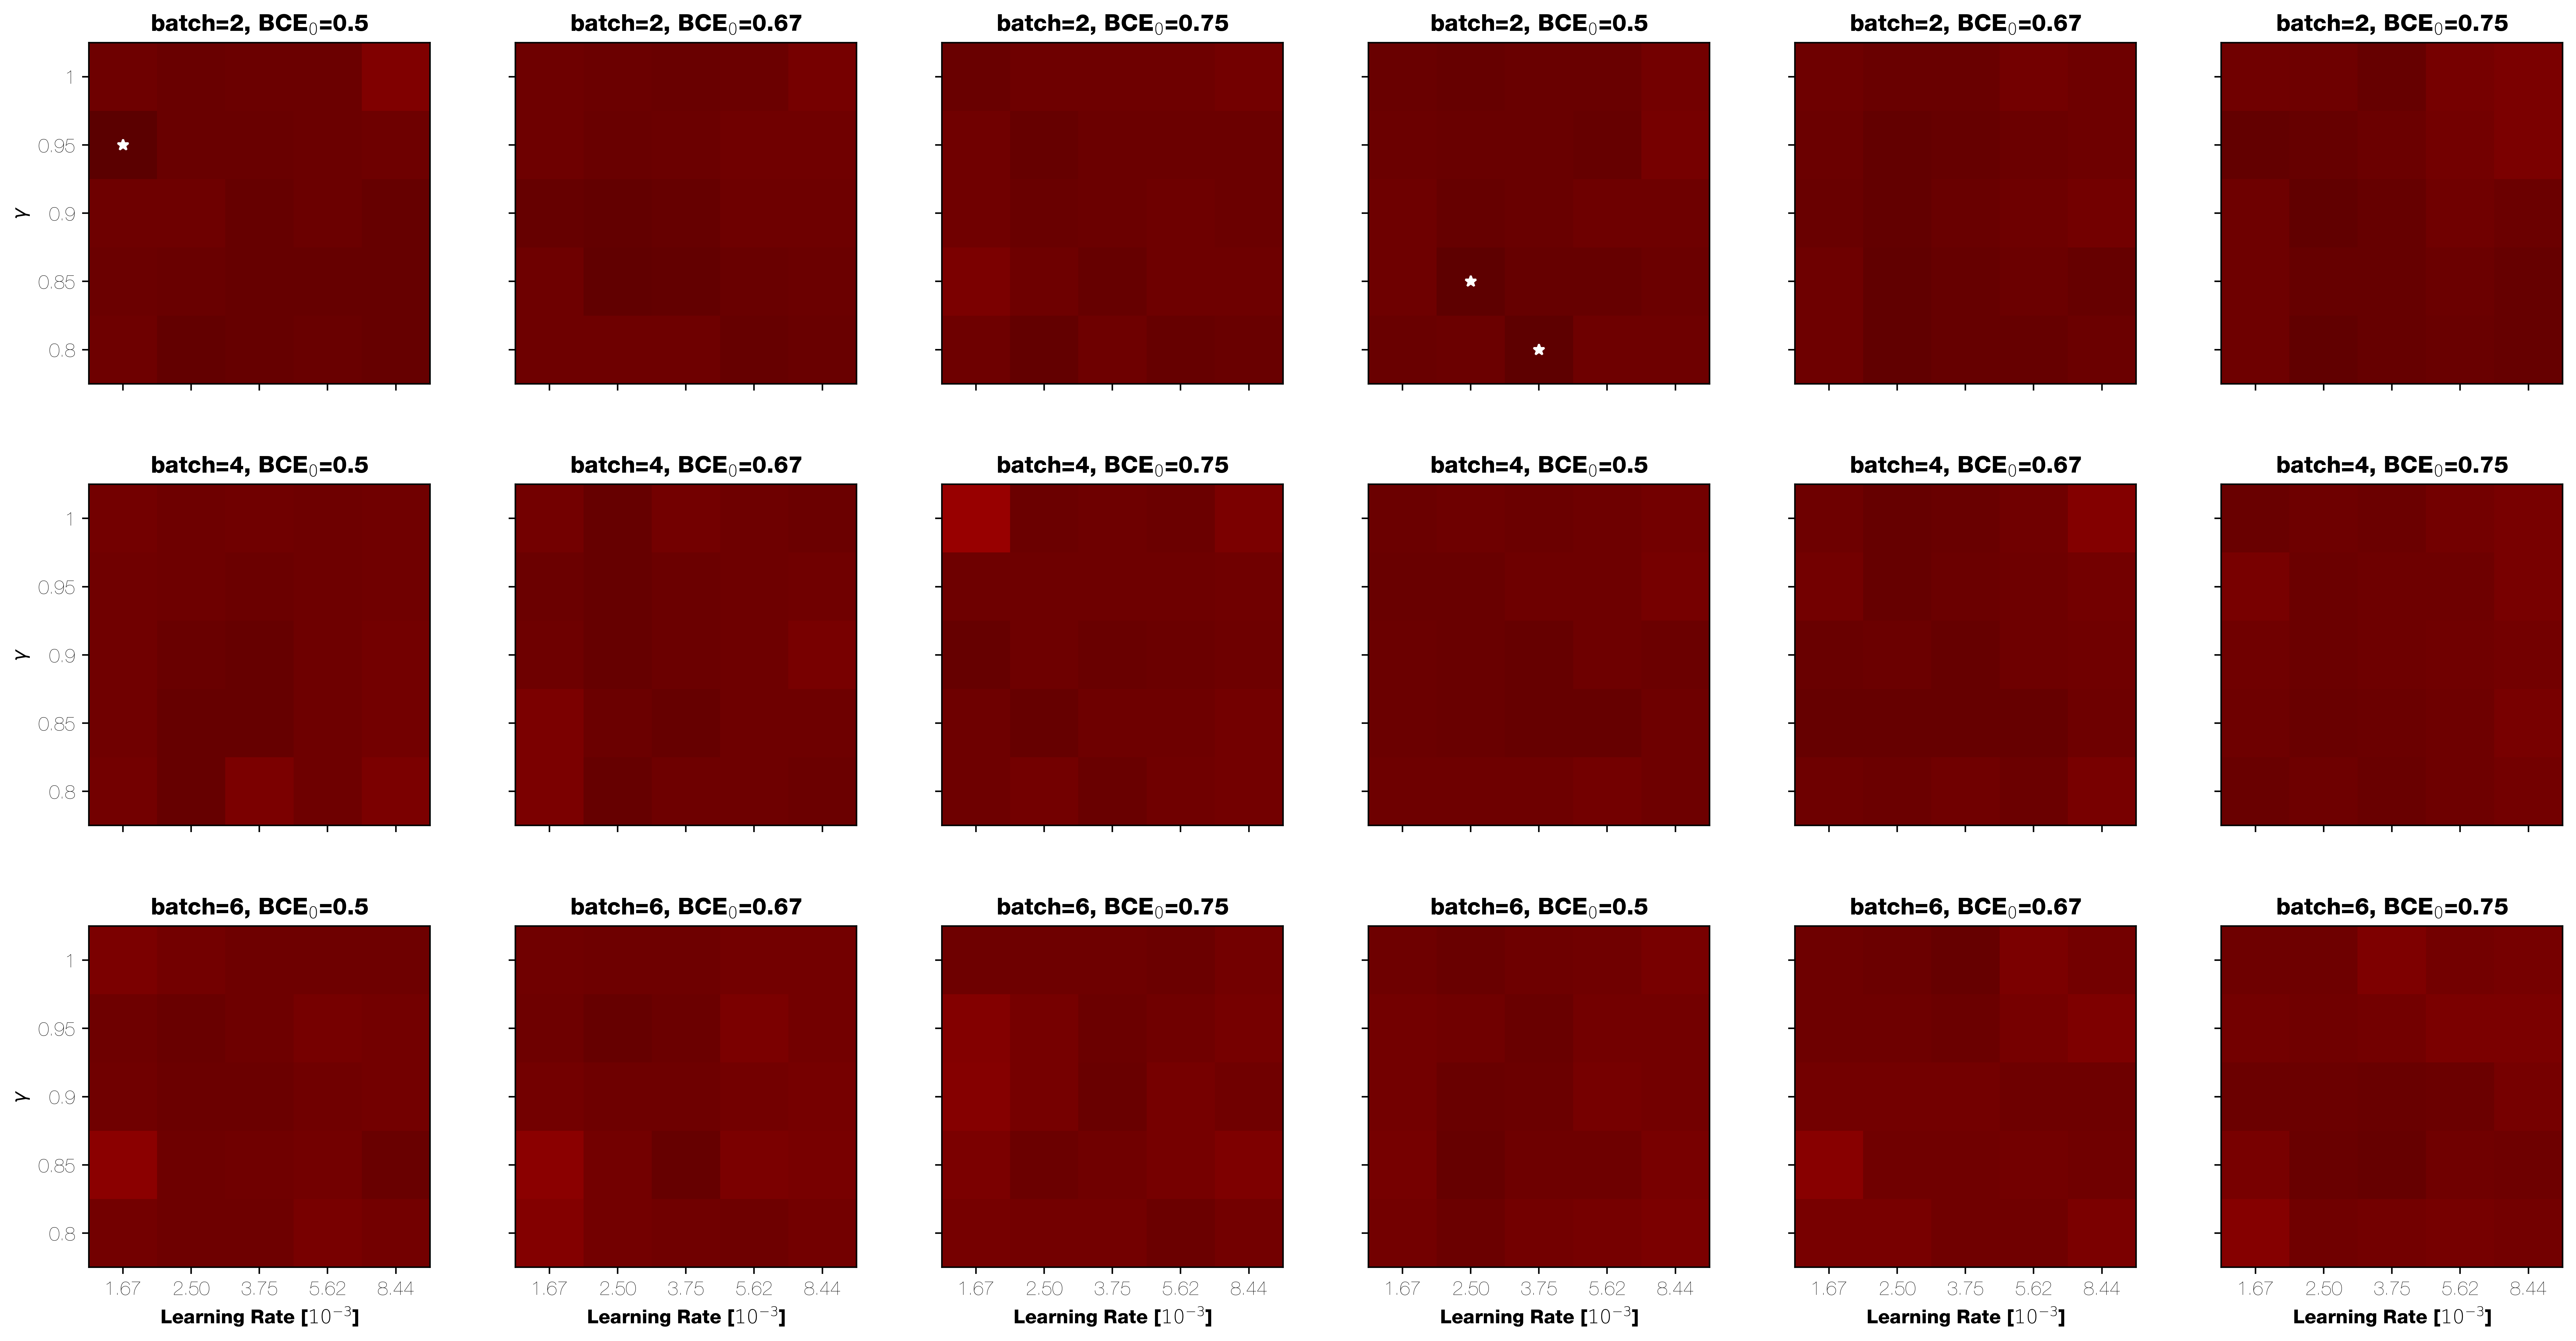

In [21]:
inputs = 'anat'
outputs = 'ring'

kws = {('anat','area'): dict(vmin=0.05, vmax=0.4, cmap='hot'),
       ('full','area'): dict(vmin=0.05, vmax=0.4, cmap='hot'),
       ('anat','ring'): dict(vmin=0.05, vmax=0.4, cmap='hot'),
       ('full','ring'): dict(vmin=0.05, vmax=0.4, cmap='hot')}
for (inputs,outputs) in [('anat','area'),('full','area'),('anat','ring'),('full','ring')]:
    kw = kws[(inputs, outputs)]

    (fig,axs) = plt.subplots(3, 6, figsize=(18,9), dpi=512, sharex=True, sharey=True)
    min18 = plotgrid(cells, inputs, outputs, 'resnet18', axes=axs[:,:3], **kw)
    min34 = plotgrid(cells, inputs, outputs, 'resnet34', axes=axs[:,3:], **kw)
    print(f'[{inputs}:{outputs}]  ResNet18: {min18["value"]:3.2f};  ResNet34: {min34["value"]:3.2f}')
    for ax in axs[:,3]:
        ax.set_ylabel('')

    fig.subplots_adjust(0,0,1,1,0.25,0.25)
    plt.show()

[]

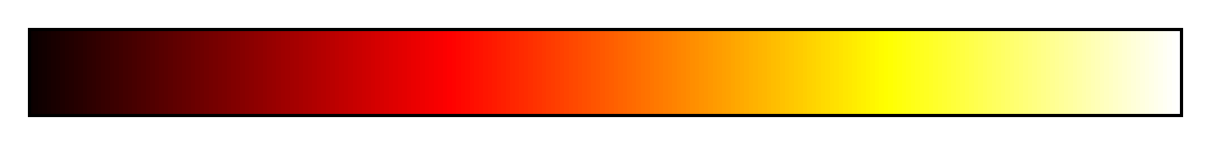

In [78]:

fig = plt.figure(figsize=(5, 0.5))
img = plt.imshow([[0.05,0.3]], cmap="hot")
plt.gca().set_visible(False)
cax = fig.add_axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
cax.set_xticks([])
#pl.savefig("colorbar.pdf")

In [79]:
def grid_versus(cells, inputs, outputs, vcol, val1, val2, col='loss_min'):
    # First get the set of cells we are planning to use:
    cells = cells[(cells['inputs'] == inputs) & (cells['prediction'] == outputs)]
    # Now pick out the cells we plan to put on each axes:
    xcells = cells[cells[vcol] == val1]
    ycells = cells[cells[vcol] == val2]
    mergecols = [k for k in ['batch_size', 'bce_weight', 'lr', 'gamma', 'base_model'] if k != vcol]
    # Now align them:
    mcells = xcells.merge(
        ycells,
        on=mergecols,
        how='inner')
    (x,y) = (mcells[col + '_x'].values, mcells[col + '_y'].values)
    return (x,y)

mu(x-y) = -1.791e-3; se(x-y) = +0.420e-3


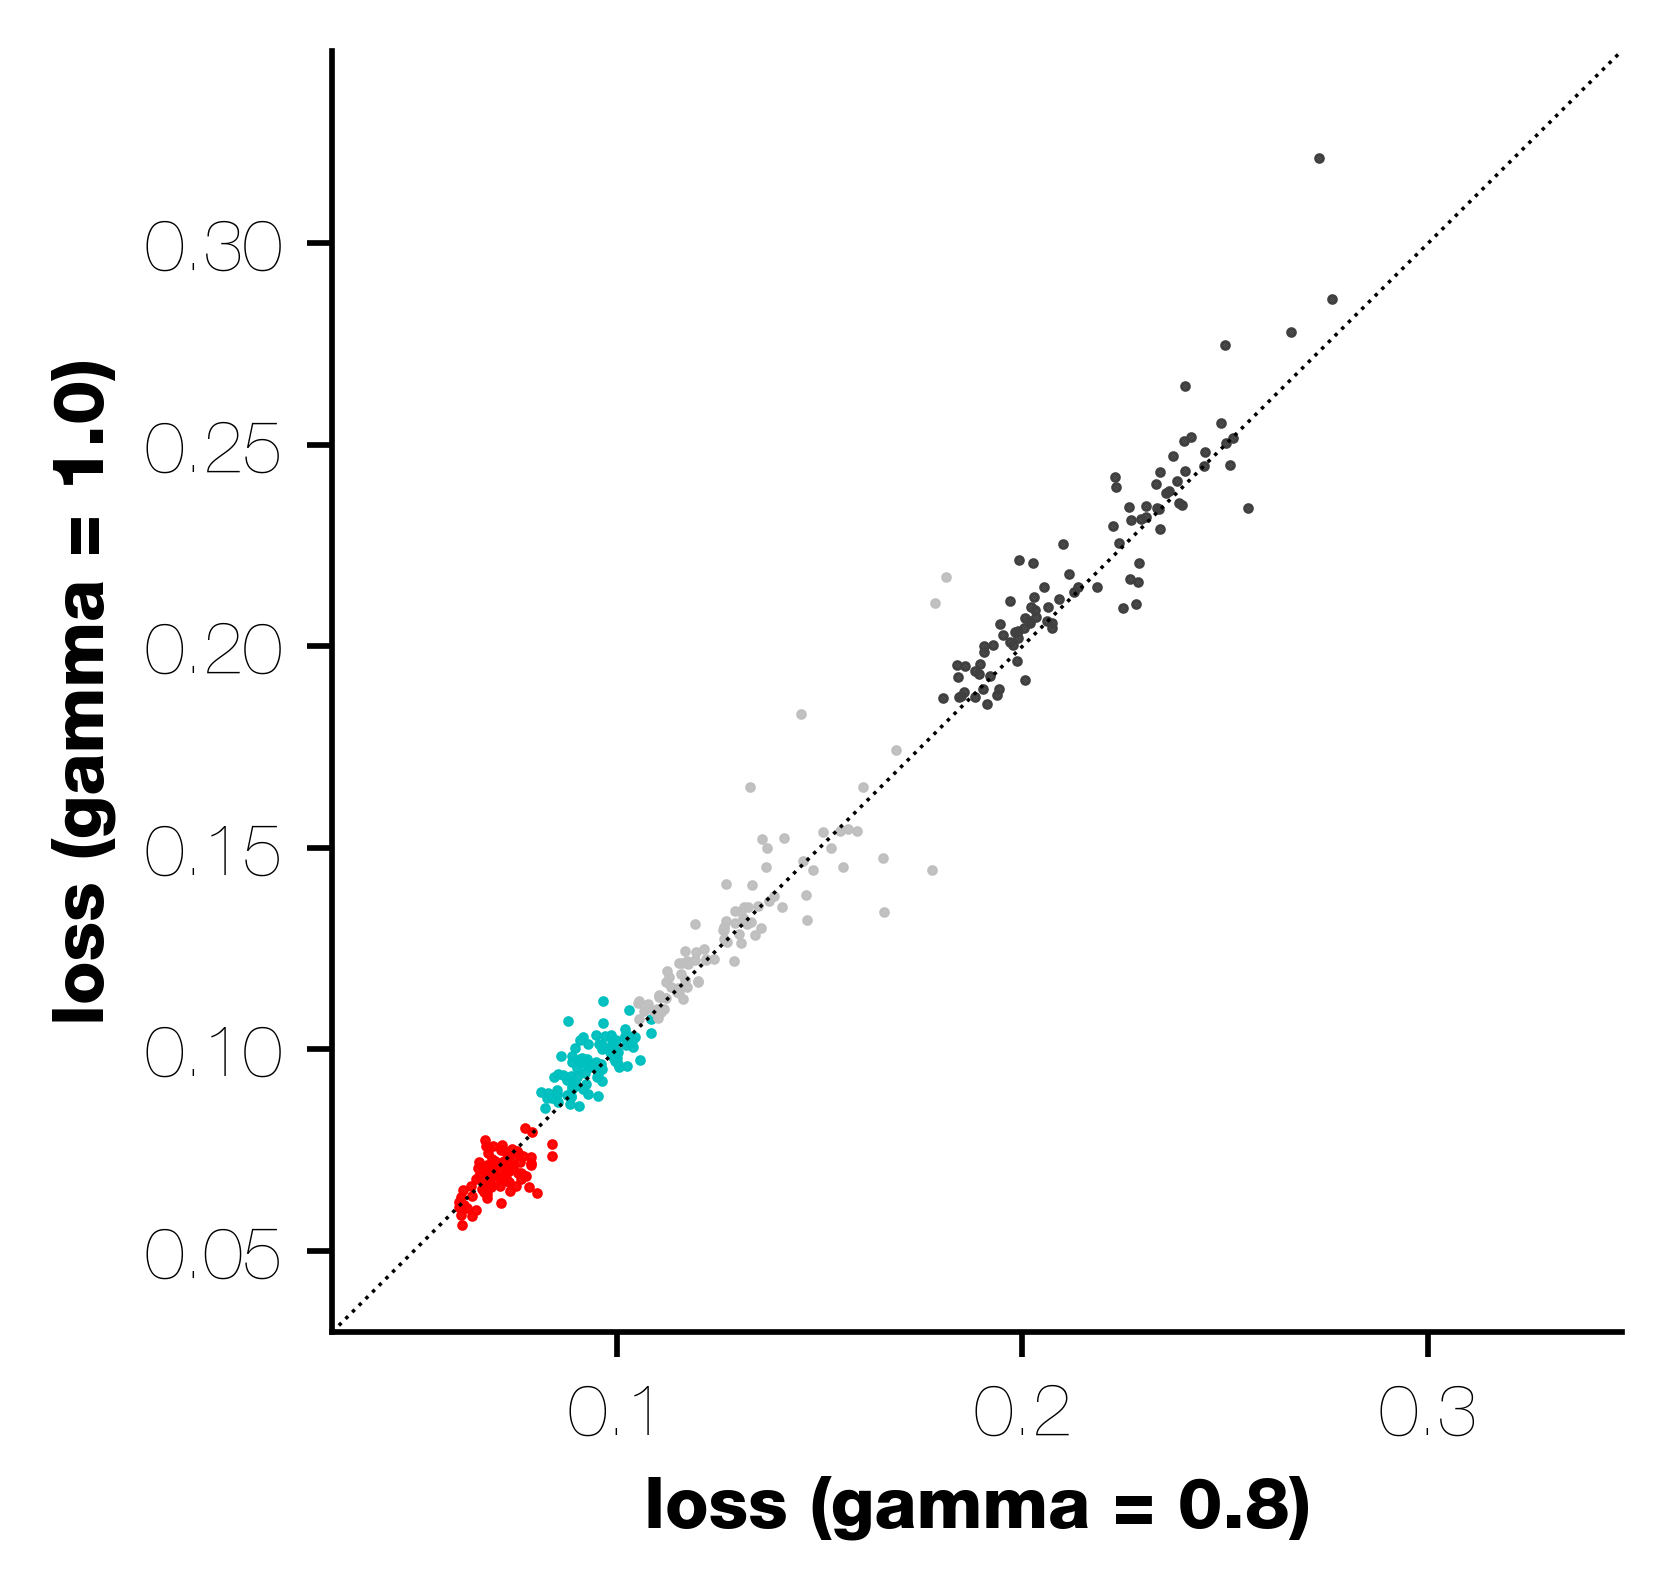

In [96]:
#(vcol, valx, valy) = ('base_model', 'resnet18', 'resnet34')
#(vcol, valx, valy) = ('batch_size', 2, 4)
#(vcol, valx, valy) = ('bce_weight', 0.67, 0.75)
#(vcol, valx, valy) = ('lr', 0.00167, 0.00844)
#(vcol, valx, valy) = ('lr', 0.00250, 0.00562)
#(vcol, valx, valy) = ('lr', 0.00167, 0.00250)
(vcol, valx, valy) = ('gamma', 0.8, 1.0)

(x1,y1) = grid_versus(cells, 'full', 'area', vcol, valx, valy)
(x2,y2) = grid_versus(cells, 'full', 'ring', vcol, valx, valy)
(x3,y3) = grid_versus(cells, 'anat', 'area', vcol, valx, valy)
(x4,y4) = grid_versus(cells, 'anat', 'ring', vcol, valx, valy)

x = np.concatenate([x1,x2,x3,x4])
y = np.concatenate([y1,y2,y3,y4])
mn = np.nanmin([x, y])
mx = np.nanmax([x, y])
rng = (mx-mn)
mx += rng/10
mn -= rng/10

(fig,ax) = plt.subplots(1,1, figsize=(3.25,3.25), dpi=512)

ax.plot(x1, y1, '.', c='r', ms=1, label='full:area')
ax.plot(x2, y2, '.', c='c', ms=1, label='full:ring')
ax.plot(x3, y3, '.', c='0.75', ms=1, label='anat:area')
ax.plot(x4, y4, '.', c='0.25', ms=1, label='anat:ring')

diffmu = np.nanmean((x - y))
diffse = np.nanstd((x - y))/np.sqrt(np.sum(np.isfinite(x + y)))
print(f'mu(x-y) = {diffmu*1000:+4.3f}e-3; se(x-y) = {diffse*1000:+4.3f}e-3')

ax.set_xlim([mn, mx])
ax.set_ylim([mn, mx])
ax.plot([mn, mx], [mn, mx], 'k:', lw=0.5)
if   vcol == 'base_model': vcol = 'model'
elif vcol == 'batch_size': vcol = 'batch size'
elif vcol == 'lr': vcol = 'learning rate'
elif vcol == 'bce_weight': vcol = 'BCE weight'
ax.set_xlabel(f'loss ({vcol} = {valx})', fontsize=10)
ax.set_ylabel(f'loss ({vcol} = {valy})', fontsize=10)
#fig.legend(loc='center right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

pass

In [90]:
def cellgrid(cells, select, col='loss_min', vmin=0, vmax=0.2, cmap='cividis'):
    # Make the four grids
    mtcs = [
        [cellselect(cells, col, inputs=ii, prediction=pp, **kw)
         for ii in ('anat', 'full')]
        for pp in ['area', 'ring']]
    # Make the plots.
    (fig,axs) = plt.subplots(
        2, 2,
        figsize=(7,7), dpi=256,
        sharex=True, sharey=True)
    fig.subplots_adjust(0,0,1,1,0.25,0.25)
    for (axrow, mtxrow) in zip(axs, mtcs):
        for (ax, mtx) in zip(axrow, mtxrow):
            hh = ax.imshow(mtx, vmin=, vmax=0.2, cmap=cmap)
    plt.colorbar(hh)
    return (fig, axs)

In [29]:
for (fmap,h) in zip(valmaps[sid], ['lh','rh']):
    trueprop = fmap.prop('A1_visual_area')
    predprop = fmap.prop('full_visual_area')
    ds = va.dice_scores(trueprop, predprop, smooth=0)
    print(f'{h}: {np.mean(ds)};  {ds}')

lh: 0.863993260769773;  [0.9341131945639085, 0.8984050688223727, 0.7594615189230378]
rh: 0.9019912693887657;  [0.934010152284264, 0.9171468309159547, 0.8548168249660787]


In [329]:
sid = 131217
surf = 'inflated'

rot = {'lh': [0,0,-np.pi/4],
       'rh': [0,0,np.pi/4]}
trl = {'lh': [-50, 0, 0],
       'rh': [50, 0, 0]}
pathdata = ny.data['hcp_lines'].native_paths['mean']

#fig = ipv.figure(width=800,height=400)

sub = valsubjects[sid]
lh = sub.lh.surface(surf).rotate(rot['lh']).translate(trl['lh'])
rh = sub.rh.surface(surf).rotate(rot['rh']).translate(trl['rh'])
fig = ny.cortex_plot(lh, figure=fig,
                     color='prf_polar_angle',
                     mask=('prf_variance_explained', 0.1, 1))
ny.cortex_plot(rh, figure=fig,
               color='prf_polar_angle',
               mask=('prf_variance_explained', 0.1, 1))

lines = {'iso_angle': ['V1_ventral','V1_dorsal',
                       'V2_ventral','V2_dorsal',
                       'V3_ventral','V3_dorsal'],
         'iso_eccen': ['7']}
for (k,lns) in lines.items():
    for ln in lns:
        for h in ['lh','rh']:
            from neuropythy.geometry.util import rotation_matrix_3D
            pdat = pathdata[sid][h][k][ln]
            xyz = pdat.coordinates[surf]
            (pitch,roll,yaw) = rot[h]
            rm = np.dot(np.dot(rotation_matrix_3D([1,0,0], pitch),
                               rotation_matrix_3D([0,1,0], roll)),
                    rotation_matrix_3D([0,0,1], yaw))
            xyz = np.dot(rm, xyz)
            xyz = xyz + np.array(trl[h])[:,None]
            (x,y,z) = xyz
            ipv.scatter(x, y, z, color='black', size=0.4)
        
#ipv.show()
fig

Figure(camera=PerspectiveCamera(fov=0.644570721372708, matrixWorldNeedsUpdate=True, position=(0.0, -100.0, 0.0…

## Notes

### Precaching Features

It can be useful to precache the feature images prior to training. This can be done using code similar to the following.

```python
# What inputs do we want to precache?
inputs = input_properties['full']
# What outputs do we want to precache?
outputs = output_properties['pred']

# Start by making datasets that use these inputs/outputs.
dsets = va.make_datasets(inputs,
                         outputs,
                         partition=(trn_sids, val_sids),
                         features=features,
                         cache_path=data_cache_path)

# This is the function we plan to run across many cores; it should be passed
# a tuple of (sid, dataset).
def precache_all(sid_ds):
    (sid, ds) = sid_ds
    # The dataset's image-cache object knows about caching.
    imcache = ds.image_cache
    # We want to cache all the data for this subject, so we loop over raters.
    for r in ('A1','A2','A3','A4'):
        # We make a target object for this rater/subject.
        targ = {'rater':r, 'subject':sid}
        if targ not in ds.targets:
            continue
        # And we ask the image-cache to precache these features.
        # Since this function will already be called in a separate process,
        # we don't need to multiprocess this request.
        imcache.precache_features(targ, inputs, multiproc=False)
    return True
```

The following code-block can then be run in a separate cell (the multiprocessing call cannot be in the same cell as the definition of the function that is being multiprocessed—in this case `precache_all`).

```python
import multiprocessing as mp

nproc = 10

trn_ds = dsets['trn']
val_ds = dsets['val']
jobs = [(sid,ds)
        for (sids,ds) in zip([trn_sids,val_sids], [trn_ds,val_ds])
        for sid in sids]
njobs = len(jobs)
for ii in range(0, njobs, nproc):
    jj = min(njobs, ii + nproc)
    nwork = jj - ii + 1
    with mp.Pool(nwork) as pool:
        pool.map(precache_all, jobs[ii:jj])
```